In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, ReLU, BatchNormalization, Input, Flatten, Concatenate, Reshape,\
Activation, Conv2DTranspose, LeakyReLU, Dropout
from keras import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.metrics import Mean

from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from keras.losses import BinaryCrossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

pd.set_option('display.max_columns', None)

## Load CelebA data set

In [2]:
data_set = 'celeba'
IMG_SHAPE = (64, 64, 3)
batch_size = 64

In [3]:
# Load the attribute vectors
# Note: Added 'Filename' at the beginning of header line in .txt file to match the number of columns in each line in file
labels_file = Path('../data/input/list_attr_celeba.txt')
labels = pd.read_csv(labels_file, header=1, sep='\s+')

In [4]:
labels.head()

,Filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [11]:
labels['Wearing_Hat'].value_counts()

-1    192781
 1      9818
Name: Wearing_Hat, dtype: int64

In [5]:
labels.drop(columns=['Filename']).sum().sort_values(ascending=False)

No_Beard               135717
Young                  110869
Attractive               5067
Mouth_Slightly_Open     -6715
Smiling                 -7261
Wearing_Lipstick       -11169
High_Cheekbones        -18221
Male                   -33731
Heavy_Makeup           -45819
Wavy_Hair              -73111
Oval_Face              -87465
Pointy_Nose            -90179
Arched_Eyebrows        -94419
Big_Lips              -105029
Black_Hair            -105655
Big_Nose              -107567
Straight_Hair         -118155
Brown_Hair            -119455
Bags_Under_Eyes       -119707
Wearing_Earrings      -126047
Bangs                 -141181
Blond_Hair            -142633
Bushy_Eyebrows        -144993
Wearing_Necklace      -152773
Narrow_Eyes           -155941
5_o_Clock_Shadow      -157567
Receding_Hairline     -170273
Wearing_Necktie       -173135
Rosy_Cheeks           -175969
Eyeglasses            -176213
Goatee                -177167
Chubby                -179273
Sideburns             -179701
Blurry    

In [12]:
# Pick subset of facial features
attr_subset = ['Male', 'Smiling', 'Mouth_Slightly_Open', 'Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Straight_Hair', 'Wavy_Hair', 'No_Beard', 'Eyeglasses', 'Pale_Skin', 'Oval_Face', 'Wearing_Hat']
labels_subset = labels[['Filename'] + attr_subset]

In [15]:
len(attr_subset)

14

In [16]:
labels_subset.head()

,Filename,Male,Smiling,Mouth_Slightly_Open,Bald,Black_Hair,Blond_Hair,Brown_Hair,Straight_Hair,Wavy_Hair,No_Beard,Eyeglasses,Pale_Skin,Oval_Face,Wearing_Hat
0,000001.jpg,-1,1,1,-1,-1,-1,1,1,-1,1,-1,-1,-1,-1
1,000002.jpg,-1,1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1
2,000003.jpg,1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1
3,000004.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1
4,000005.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1


In [17]:
def celeba_transform(x):
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SHAPE[:2])
    return ((tf.cast(img, tf.float32) - 127.5) / 127.5)

In [18]:
batch_size = 64

In [19]:
train_data = tf.data.Dataset.from_tensor_slices((labels_subset['Filename'].values, labels_subset[attr_subset].values))\
            .map(lambda x, y: ( ('../data/input/celeba/'+ x), y))\
            .map(lambda x, y: (celeba_transform(x), y))\
            .shuffle(buffer_size=20000)\
            .batch(batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).repeat()

In [20]:
for batch in train_data:
    break

In [21]:
batch[1][:10]

<tf.Tensor: shape=(10, 14), dtype=int64, numpy=
array([[-1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1],
       [ 1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1],
       [ 1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1],
       [-1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1],
       [-1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1],
       [ 1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1],
       [ 1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1]],
      dtype=int64)>

C:\Users\Chirag\AppData\Local\Temp\ipykernel_40776\2607381412.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


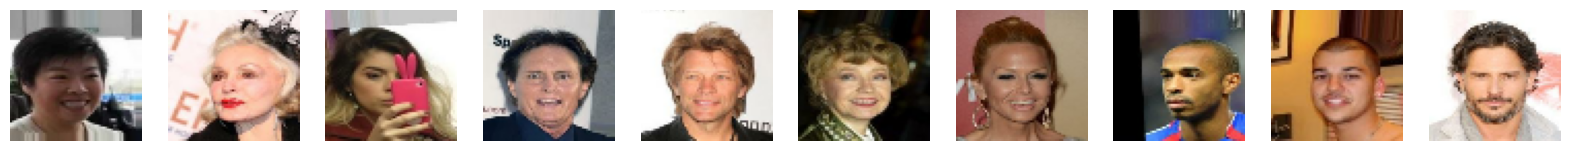

In [22]:
fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(np.clip(batch[0][i]*127.5 + 127.5, 0, 255).astype(int))
    ax[i].axis('off')
fig.show()

## Define Conditional GAN model class

In [40]:
class CGAN(keras.Model):
    def __init__(self, num_classes, latent_dim=100, kernel_size=5):
        super().__init__()
        self.num_classes = num_classes
        self.z_dim = latent_dim
        self.kernel_size = kernel_size
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()
        
    def compile_model(self, discriminator_optimizer, generator_optimizer, loss_fn):
        super().compile(run_eagerly=False)
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        
        self.discriminator_loss_metric = Mean(name='d_loss')
        self.generator_loss_metric = Mean(name='g_loss')
        
    def _build_generator(self):
        img = Input((self.z_dim,))
        labels = Input((self.num_classes,))
        
#         labels_z = Dense(self.z_dim)(labels)
#         labels_z = LeakyReLU()(labels_z)
        
        z = Concatenate()([img, labels])
        
        z = Dense(8*8*512)(z)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Reshape((8, 8, 512))(z)
        
        num_filters = [512, 256, 128, 64]
        strides = [2, 2, 2, 1]
        for i, f in enumerate(num_filters):
            z = Conv2DTranspose(
                filters=f,
                kernel_size=self.kernel_size,
                strides=strides[i],
                padding='same',
            )(z)
            z = BatchNormalization()(z)
            z = LeakyReLU(alpha=0.2)(z)
            z = Dropout(0.2)(z)
            
        output = Conv2D(
            filters=3,
            kernel_size=5,
            strides=1,
            padding='same',
            activation='tanh',
        )(z)

        return Model(inputs=[img, labels], outputs=output, name='Generator')
    
    def _build_discriminator(self):
        img = Input(IMG_SHAPE)
        labels = Input((self.num_classes,))
        
        z = Conv2D(
            filters=64,
            kernel_size=self.kernel_size,
            strides=2,
            padding='same',
        )(img)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Conv2D(
            filters=128,
            kernel_size=self.kernel_size,
            strides=2,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Conv2D(
            filters=256,
            kernel_size=self.kernel_size,
            strides=2,
            padding='same',
        )(z)
        z = BatchNormalization()(z)
        z = LeakyReLU()(z)
        
        z = Flatten()(z)
        z = Dropout(0.2)(z)
        
        z = Dense(256)(z)
        z = LeakyReLU()(z)
        z = Dropout(0.2)(z)
        
#         labels_z = Dense(256)(labels) 
#         labels_z = LeakyReLU()(labels_z)
#         labels_z = Dropout(0.2)(labels_z)
        
        z = Concatenate()([z, labels])
        
        z = Dense(128)(z)
        z = LeakyReLU()(z)
        z = Dropout(0.2)(z)
        
        z = Dense(10)(z)
        z = LeakyReLU()(z)
        
        output = Dense(1, activation='sigmoid')(z)
        
        return Model(inputs=[img, labels], outputs=output, name='Discriminator')
    
    def train_step(self, batch_data):
        img, labels = batch_data
        batch_size = tf.shape(img)[0]
        real_target_labels = tf.ones((batch_size, 1))
        fake_target_labels = tf.zeros((batch_size, 1))
        
        # Discriminator Loss
        with tf.GradientTape() as tape:
            real_target_labels_noisy = real_target_labels - 0.1 * tf.random.uniform(tf.shape(real_target_labels))
            predictions = self.discriminator((img, labels))
            d_loss = 0.5*self.loss_fn(real_target_labels_noisy, predictions)
                
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
        
        with tf.GradientTape() as tape:
            z = tf.random.normal((batch_size, self.z_dim))
            fake_img = self.generator((z, labels))
            fake_target_labels_noisy = fake_target_labels + 0.1 * tf.random.uniform(tf.shape(fake_target_labels))
            predictions = self.discriminator((fake_img, labels))
            d_loss = 0.5*self.loss_fn(fake_target_labels_noisy, predictions)
        
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
            
        with tf.GradientTape() as tape:
            # Generator Loss
            z = tf.random.normal((batch_size, self.z_dim))
            fake_img = self.generator((z, labels))
            fake_predictions = self.discriminator((fake_img, labels))
            g_loss = self.loss_fn(real_target_labels, fake_predictions)
            
        gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))
        
        self.discriminator_loss_metric.update_state(d_loss)
        self.generator_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]

## Define Callback

In [41]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.z_dim = latent_dim
        self.z = tf.random.normal((10, 10, self.z_dim))
        self.labels = tf.convert_to_tensor(labels_subset[attr_subset].sample(10))
        
    def on_train_begin(self, logs):
        self.d_losses = []
        self.g_losses = []
        
    def on_batch_end(self, batch, logs):
        self.d_losses.append(logs['d_loss'])
        self.g_losses.append(logs['g_loss'])
        
    def on_epoch_end(self, epoch, logs):
        fig, ax = plt.subplots(10, 10, figsize=(20, 20))
        for i in range(10):
            generated_faces = self.model.generator((self.z[i], self.labels), training=False)
            for j in range(10):
                ax[j][i].matshow(np.clip(generated_faces[j]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
                ax[j][i].axis('off')
        fig.savefig(f"../data/tmp/celeba/generated_faces_{epoch+1:03}.png")
        plt.close()
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(self.d_losses, label='Discriminator loss')
        ax.plot(self.g_losses, label='Generator loss')
        ax.legend()
        fig.savefig(f"../data/tmp/celeba/training_losses.png")
        plt.close()
        
    def on_train_end(self, logs):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(self.d_losses, label='Discriminator loss')
        ax.plot(self.g_losses, label='Generator loss')
        ax.legend()
        fig.savefig(f"../data/tmp/celeba/training_losses.png")
        plt.close()

In [42]:
callback = CustomCallback(latent_dim=128)

In [43]:
pd.DataFrame(data=callback.labels, columns=attr_subset)

,Male,Smiling,Mouth_Slightly_Open,Bald,Black_Hair,Blond_Hair,Brown_Hair,Straight_Hair,Wavy_Hair,No_Beard,Eyeglasses,Pale_Skin,Oval_Face,Wearing_Hat
0,1,-1,1,-1,-1,-1,1,-1,1,1,-1,-1,-1,-1
1,1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1
2,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1
3,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
4,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1
5,-1,-1,1,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1
6,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1
7,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1
8,-1,1,1,-1,1,-1,-1,-1,-1,1,-1,-1,1,-1
9,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1


## Define parameters

In [52]:
epochs = 500
generator_lr = 2e-4
discriminator_lr = 1e-4

generator_optimizer = Adam(learning_rate=generator_lr)
discriminator_optimizer = Adam(learning_rate=discriminator_lr)

loss_fn = BinaryCrossentropy()

## Train CGAN model

In [53]:
latent_dim = 128
num_classes = len(attr_subset)

In [54]:
cgan = CGAN(num_classes=num_classes, latent_dim=latent_dim, kernel_size=4)

In [55]:
cgan.compile_model(discriminator_optimizer, generator_optimizer, loss_fn)

In [56]:
# cgan.generator.summary()

## GAN Training Hacks (https://github.com/soumith/ganhacks)

### Tracking failures early
- D loss goes to 0: failure mode
- check norms of gradients: if they are over 100 things are screwing up
- when things are working, D loss has low variance and goes down over time vs having huge variance and spiking
- if loss of generator steadily decreases, then it's fooling D with garbage (says martin)

In [57]:
try:
    cgan.fit(train_data,
             epochs=epochs,
             initial_epoch=0,
             steps_per_epoch=1000,
             callbacks=[callback],
            )
except Exception as e:
    print(e)
    callback.on_train_end(None)

Epoch 1/500
1000/1000 [==============================] - 263s 237ms/step - d_loss: 0.1194 - g_loss: 2.9650
Epoch 2/500
1000/1000 [==============================] - 246s 246ms/step - d_loss: 0.1827 - g_loss: 2.5312
Epoch 3/500
1000/1000 [==============================] - 153s 153ms/step - d_loss: 0.1953 - g_loss: 2.1397
Epoch 4/500
1000/1000 [==============================] - 182s 182ms/step - d_loss: 0.1835 - g_loss: 2.1872
Epoch 5/500
1000/1000 [==============================] - 161s 160ms/step - d_loss: 0.1760 - g_loss: 2.1772
Epoch 6/500
1000/1000 [==============================] - 155s 155ms/step - d_loss: 0.1668 - g_loss: 2.3668
Epoch 7/500
1000/1000 [==============================] - 176s 175ms/step - d_loss: 0.1482 - g_loss: 2.6130
Epoch 8/500
1000/1000 [==============================] - 157s 157ms/step - d_loss: 0.1399 - g_loss: 2.7934
Epoch 9/500
1000/1000 [==============================] - 149s 149ms/step - d_loss: 0.1263 - g_loss: 2.9467
Epoch 10/500
1000/1000 [=============

Epoch 77/500
1000/1000 [==============================] - 173s 173ms/step - d_loss: 0.2260 - g_loss: 1.6600
Epoch 78/500
1000/1000 [==============================] - 156s 155ms/step - d_loss: 0.2253 - g_loss: 1.6844
Epoch 79/500
1000/1000 [==============================] - 146s 145ms/step - d_loss: 0.2242 - g_loss: 1.6924
Epoch 80/500
1000/1000 [==============================] - 178s 178ms/step - d_loss: 0.2240 - g_loss: 1.6949
Epoch 81/500
1000/1000 [==============================] - 158s 158ms/step - d_loss: 0.2212 - g_loss: 1.7169
Epoch 82/500
1000/1000 [==============================] - 153s 153ms/step - d_loss: 0.2222 - g_loss: 1.7179
Epoch 83/500
1000/1000 [==============================] - 169s 169ms/step - d_loss: 0.2276 - g_loss: 1.6541
Epoch 84/500
1000/1000 [==============================] - 158s 157ms/step - d_loss: 0.2247 - g_loss: 1.6913
Epoch 85/500
1000/1000 [==============================] - 153s 153ms/step - d_loss: 0.2208 - g_loss: 1.7290
Epoch 86/500
1000/1000 [====

1000/1000 [==============================] - 165s 165ms/step - d_loss: 0.2082 - g_loss: 1.9262
Epoch 153/500
1000/1000 [==============================] - 172s 172ms/step - d_loss: 0.2048 - g_loss: 1.9440
Epoch 154/500
1000/1000 [==============================] - 131s 131ms/step - d_loss: 0.2065 - g_loss: 1.9392
Epoch 155/500
1000/1000 [==============================] - 126s 126ms/step - d_loss: 0.2066 - g_loss: 1.9286
Epoch 156/500
1000/1000 [==============================] - 169s 169ms/step - d_loss: 0.2069 - g_loss: 1.9275
Epoch 157/500
1000/1000 [==============================] - 159s 159ms/step - d_loss: 0.2047 - g_loss: 1.9369
Epoch 158/500
1000/1000 [==============================] - 152s 152ms/step - d_loss: 0.2058 - g_loss: 1.9557
Epoch 159/500
1000/1000 [==============================] - 171s 171ms/step - d_loss: 0.2046 - g_loss: 1.9406
Epoch 160/500
1000/1000 [==============================] - 159s 159ms/step - d_loss: 0.2032 - g_loss: 1.9677
Epoch 161/500
1000/1000 [========

1000/1000 [==============================] - 157s 157ms/step - d_loss: 0.1866 - g_loss: 2.2569
Epoch 228/500
1000/1000 [==============================] - 165s 165ms/step - d_loss: 0.1868 - g_loss: 2.2876
Epoch 229/500
1000/1000 [==============================] - 162s 161ms/step - d_loss: 0.1849 - g_loss: 2.3059
Epoch 230/500
1000/1000 [==============================] - 157s 157ms/step - d_loss: 0.1857 - g_loss: 2.2909
Epoch 231/500
1000/1000 [==============================] - 145s 145ms/step - d_loss: 0.1845 - g_loss: 2.2847
Epoch 232/500
1000/1000 [==============================] - 180s 180ms/step - d_loss: 0.1852 - g_loss: 2.2923
Epoch 233/500
1000/1000 [==============================] - 158s 158ms/step - d_loss: 0.1846 - g_loss: 2.3014
Epoch 234/500
1000/1000 [==============================] - 152s 152ms/step - d_loss: 0.1874 - g_loss: 2.2927
Epoch 235/500
1000/1000 [==============================] - 174s 174ms/step - d_loss: 0.1860 - g_loss: 2.2814
Epoch 236/500
1000/1000 [========

1000/1000 [==============================] - 161s 161ms/step - d_loss: 0.1732 - g_loss: 2.5335
Epoch 303/500
1000/1000 [==============================] - 159s 159ms/step - d_loss: 0.1724 - g_loss: 2.5413
Epoch 304/500
1000/1000 [==============================] - 170s 170ms/step - d_loss: 0.1733 - g_loss: 2.5257
Epoch 305/500
1000/1000 [==============================] - 161s 161ms/step - d_loss: 0.1719 - g_loss: 2.5572
Epoch 306/500
1000/1000 [==============================] - 160s 160ms/step - d_loss: 0.1740 - g_loss: 2.5292
Epoch 307/500
1000/1000 [==============================] - 150s 149ms/step - d_loss: 0.1733 - g_loss: 2.5459
Epoch 308/500
1000/1000 [==============================] - 182s 182ms/step - d_loss: 0.1729 - g_loss: 2.5587
Epoch 309/500
1000/1000 [==============================] - 162s 162ms/step - d_loss: 0.1703 - g_loss: 2.5663
Epoch 310/500
1000/1000 [==============================] - 154s 154ms/step - d_loss: 0.1737 - g_loss: 2.5278
Epoch 311/500
1000/1000 [========

1000/1000 [==============================] - 172s 172ms/step - d_loss: 0.1657 - g_loss: 2.6704
Epoch 378/500
1000/1000 [==============================] - 165s 165ms/step - d_loss: 0.1632 - g_loss: 2.6803
Epoch 379/500
1000/1000 [==============================] - 162s 162ms/step - d_loss: 0.1634 - g_loss: 2.6840
Epoch 380/500
1000/1000 [==============================] - 172s 172ms/step - d_loss: 0.1638 - g_loss: 2.6708
Epoch 381/500
1000/1000 [==============================] - 162s 162ms/step - d_loss: 0.1635 - g_loss: 2.6838
Epoch 382/500
1000/1000 [==============================] - 162s 162ms/step - d_loss: 0.1610 - g_loss: 2.7164
Epoch 383/500
1000/1000 [==============================] - 171s 171ms/step - d_loss: 0.1659 - g_loss: 2.6641
Epoch 384/500
1000/1000 [==============================] - 161s 161ms/step - d_loss: 0.1635 - g_loss: 2.6958
Epoch 385/500
1000/1000 [==============================] - 163s 163ms/step - d_loss: 0.1636 - g_loss: 2.6706
Epoch 386/500
1000/1000 [========

1000/1000 [==============================] - 166s 166ms/step - d_loss: 0.1559 - g_loss: 2.7244
Epoch 453/500
1000/1000 [==============================] - 175s 175ms/step - d_loss: 0.1570 - g_loss: 2.7206
Epoch 454/500
1000/1000 [==============================] - 166s 166ms/step - d_loss: 0.1572 - g_loss: 2.7228
Epoch 455/500
1000/1000 [==============================] - 167s 167ms/step - d_loss: 0.1569 - g_loss: 2.7137
Epoch 456/500
1000/1000 [==============================] - 174s 174ms/step - d_loss: 0.1580 - g_loss: 2.7043
Epoch 457/500
1000/1000 [==============================] - 164s 164ms/step - d_loss: 0.1545 - g_loss: 2.7231
Epoch 458/500
1000/1000 [==============================] - 165s 165ms/step - d_loss: 0.1565 - g_loss: 2.7206
Epoch 459/500
1000/1000 [==============================] - 175s 175ms/step - d_loss: 0.1575 - g_loss: 2.7277
Epoch 460/500
1000/1000 [==============================] - 167s 167ms/step - d_loss: 0.1566 - g_loss: 2.7188
Epoch 461/500
1000/1000 [========

In [59]:
attr_subset

['Male',
 'Smiling',
 'Mouth_Slightly_Open',
 'Bald',
 'Black_Hair',
 'Blond_Hair',
 'Brown_Hair',
 'Straight_Hair',
 'Wavy_Hair',
 'No_Beard',
 'Eyeglasses',
 'Pale_Skin',
 'Oval_Face',
 'Wearing_Hat']

C:\Users\Chirag\AppData\Local\Temp\ipykernel_40776\2865825685.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


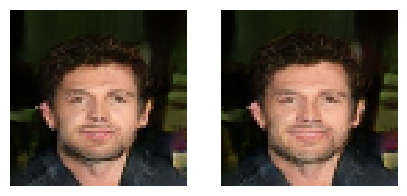

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(5, 7))
z = tf.random.normal((latent_dim,))
labels_samples = tf.convert_to_tensor([[1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
                                       [1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

# print(pd.DataFrame(labels_samples, columns=attr_subset))

generated_faces = cgan.generator((np.array([z, z]), labels_samples), training=False)

ax[0].matshow(np.clip(generated_faces[0]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
ax[0].axis('off')

ax[1].matshow(np.clip(generated_faces[1]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
ax[1].axis('off')

fig.show()

   Male  Smiling  Mouth_Slightly_Open  Bald  Black_Hair  Blond_Hair  \
0     1        1                   -1    -1           1          -1   
1    -1        1                    1    -1          -1          -1   
2     1        1                    1    -1           1          -1   
3     1       -1                   -1    -1          -1          -1   
4    -1       -1                    1    -1          -1           1   
5     1        1                   -1    -1          -1          -1   
6    -1        1                    1    -1          -1          -1   
7    -1        1                    1    -1          -1          -1   
8    -1        1                    1    -1          -1           1   
9    -1       -1                   -1    -1          -1          -1   

   Brown_Hair  Straight_Hair  Wavy_Hair  No_Beard  Eyeglasses  Pale_Skin  \
0          -1             -1          1         1          -1         -1   
1           1             -1          1         1          -1     

C:\Users\Chirag\AppData\Local\Temp\ipykernel_40776\2116006850.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


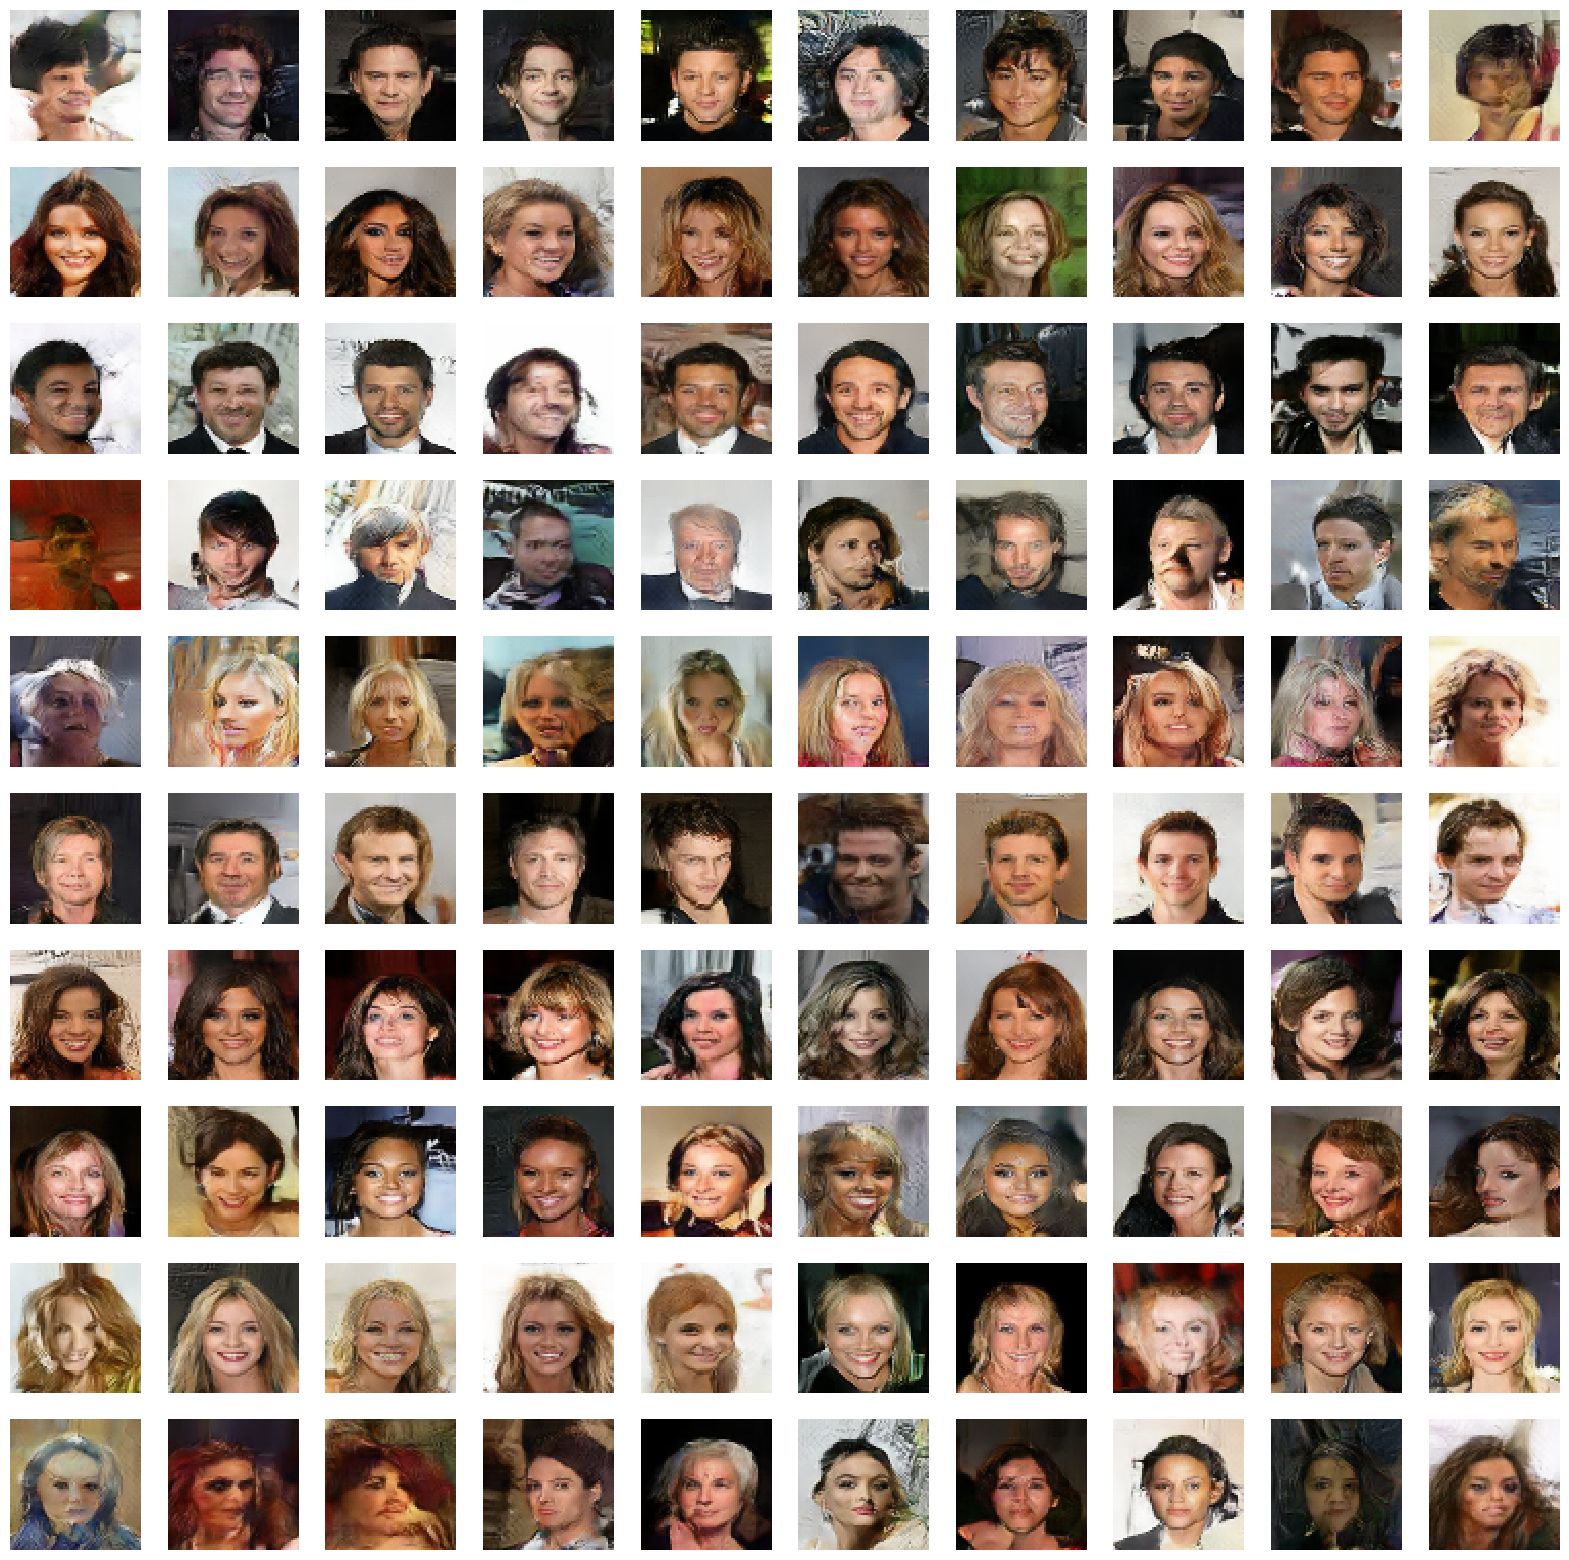

In [58]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
z = tf.random.normal((10, 10, latent_dim))
labels_samples = tf.convert_to_tensor(labels_subset[attr_subset].sample(10))

print(pd.DataFrame(labels_samples, columns=attr_subset))

for i in range(10):    
    generated_faces = cgan.generator((z[i], labels_samples), training=False)
    for j in range(10):
        ax[j][i].matshow(np.clip(generated_faces[j]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
        ax[j][i].axis('off')
fig.show()

In [218]:
def save_model(filepath: Path):
    cgan.generator.save(Path(filepath) / 'generator')
    cgan.discriminator.save(Path(filepath) / 'discriminator')

In [219]:
save_model('../data/output')

INFO:tensorflow:Assets written to: ..\data\output\generator\assets


INFO:tensorflow:Assets written to: ..\data\output\generator\assets


INFO:tensorflow:Assets written to: ..\data\output\discriminator\assets


INFO:tensorflow:Assets written to: ..\data\output\discriminator\assets
